In [3]:
## Model.py
## Initialize Sam Model (Only Once)
from samgeo import SamGeo2

sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.6,
    stability_score_thresh=0.85,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [4]:
### Get the mask  and give the polygon output also save in json file
import rasterio
import numpy as np
import cv2
from rasterio.features import shapes
from shapely.geometry import shape, mapping
from scipy import ndimage
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os

# --- Configuration ---
clean_mask_path = "masks_clean1.tif"
boundaries_path = "masks_boundaries1.tif"
polygons_geojson = "polygons.geojson"

# --- Watershed Separation (for touching objects) ---
USE_WATERSHED_SEPARATION = True  # Separate touching objects using watershed
WATERSHED_THRESHOLD = 0.2        # Lower = more aggressive separation (0.1-0.5)

# --- Morphological Processing ---
USE_MORPHOLOGY = True        # Apply morphological operations to improve shapes
MORPH_CLOSE_KERNEL = 2       # Kernel size for closing (fill small holes)
MORPH_CLOSE_ITERATIONS = 1   # How many times to apply closing
MORPH_DILATE_KERNEL = 3      # Kernel size for dilation (expand objects)
MORPH_DILATE_ITERATIONS = 1  # How many times to dilate
MORPH_ERODE_KERNEL = 3       # Kernel size for erosion (shrink back slightly)
MORPH_ERODE_ITERATIONS = 1   # How many times to erode (use to smooth after dilation)

# --- Filtering Parameters ---
MIN_AREA = 2000              # Minimum area in pixels (increase to remove smaller blobs)
MAX_AREA = 5000000          # Maximum area (remove if too large)

# Shape quality filters
MIN_COMPACTNESS = 0.01       # Remove irregular shapes (0-1, higher = more compact)
MIN_SOLIDITY = 0.2          # Remove fragmented shapes (0-1, area/convex_hull)
MAX_ASPECT_RATIO = 200.0      # Remove elongated shapes (width/height ratio)
MIN_CONVEXITY = 0.3         # Remove concave/irregular shapes (0-1)
MIN_EXTENT = 0.05            # Remove thin/sparse shapes (area/bounding_box)

BOUNDARY_THICKNESS = 4      
CREATE_BOUNDARY_FILE = True
SAVE_GEOJSON = True

def load_sam_mask(mask_path):
    """Load SAM mask and convert to instance mask"""
    with rasterio.open(mask_path) as src:
        mask_data = src.read()
        profile = src.profile.copy()
        transform = src.transform
        crs = src.crs
        
    # Handle multi-band masks
    if mask_data.ndim == 3 and mask_data.shape[0] > 1:
        
        instance_mask = np.zeros(mask_data.shape[1:], dtype=np.uint16)
        
        valid_bands = 0
        for band_idx in range(mask_data.shape[0]):
            band = mask_data[band_idx]
            nonzero = np.count_nonzero(band > 0)
            
            if nonzero > 0:
                valid_bands += 1
                band_mask = band > 0
                instance_mask[band_mask & (instance_mask == 0)] = band_idx + 1
        
    else:
        instance_mask = mask_data.squeeze()
        if np.max(instance_mask) > 1:  # multi-object in single band
            instance_mask = instance_mask
        else:  # binary mask, label connected regions
            instance_mask, _ = ndimage.label(instance_mask > 0)
    
    return instance_mask, profile, transform, crs

def apply_watershed_separation(instance_mask):
    """
    Apply watershed algorithm to separate touching objects
    This is useful when SAM detects objects that are touching/overlapping
    
    Parameters:
    -----------
    instance_mask : numpy.ndarray
        Instance mask where objects might be touching
    
    Returns:
    --------
    numpy.ndarray : Instance mask with separated objects
    """
    if not USE_WATERSHED_SEPARATION:
        return instance_mask
    
    
    # Create binary mask of all objects
    binary_mask = (instance_mask > 0).astype(np.uint8)
    
    # Distance transform to find object centers
    dist = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 3)
    
    # Normalize distance
    dist_norm = cv2.normalize(dist, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Find local maxima (object centers) with configurable threshold
    _, peaks = cv2.threshold(dist_norm, WATERSHED_THRESHOLD * dist_norm.max(), 255, cv2.THRESH_BINARY)
    peaks = peaks.astype(np.uint8)
    
    # Label the peaks (these become watershed markers)
    _, markers = cv2.connectedComponents(peaks)
    
    # Small dilation of markers to ensure they're inside objects
    kernel = np.ones((2, 2), np.uint8)
    markers = cv2.dilate(markers.astype(np.uint8), kernel, iterations=1)
    markers = markers.astype(np.int32)
    
    # Mark background
    markers[binary_mask == 0] = 0
    
    # Apply watershed
    binary_3ch = cv2.cvtColor(binary_mask * 255, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(binary_3ch, markers)
    
    # Create separated instance mask
    # Watershed boundaries are marked as -1, we set them to 0
    separated_mask = np.where(markers > 0, markers, 0).astype(np.uint16)
    
    
    return separated_mask

def apply_morphological_operations(instance_mask):
    """
    Apply morphological operations to improve object shapes
    - Closing: fills small holes and gaps
    - Dilation: expands objects, smooths edges
    - Erosion: shrinks objects back (optional, for smoothing)
    """
    if not USE_MORPHOLOGY:
        return instance_mask
    
    unique_ids = np.unique(instance_mask)
    unique_ids = unique_ids[unique_ids > 0]
    
    improved_mask = np.zeros_like(instance_mask, dtype=np.uint16)
    
    for inst_id in unique_ids:
        obj_mask = (instance_mask == inst_id).astype(np.uint8)
        
        # 1. Morphological Closing (fill small holes and gaps)
        if MORPH_CLOSE_KERNEL > 0 and MORPH_CLOSE_ITERATIONS > 0:
            close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                                     (MORPH_CLOSE_KERNEL, MORPH_CLOSE_KERNEL))
            obj_mask = cv2.morphologyEx(obj_mask, cv2.MORPH_CLOSE, close_kernel, 
                                       iterations=MORPH_CLOSE_ITERATIONS)
        
        # 2. Dilation (expand object, smooth edges)
        if MORPH_DILATE_KERNEL > 0 and MORPH_DILATE_ITERATIONS > 0:
            dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                                      (MORPH_DILATE_KERNEL, MORPH_DILATE_KERNEL))
            obj_mask = cv2.dilate(obj_mask, dilate_kernel, iterations=MORPH_DILATE_ITERATIONS)
        
        # 3. Erosion (shrink back slightly to smooth, optional)
        if MORPH_ERODE_KERNEL > 0 and MORPH_ERODE_ITERATIONS > 0:
            erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                                     (MORPH_ERODE_KERNEL, MORPH_ERODE_KERNEL))
            obj_mask = cv2.erode(obj_mask, erode_kernel, iterations=MORPH_ERODE_ITERATIONS)
        
        # Assign to output mask
        improved_mask[obj_mask > 0] = inst_id
    
    return improved_mask

def calculate_shape_metrics(obj_mask):
    """
    Calculate shape quality metrics for filtering
    
    Returns:
    --------
    dict : Shape metrics (area, compactness, solidity, aspect_ratio, etc.)
    """
    # Find contours
    contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    
    contour = max(contours, key=cv2.contourArea)
    
    # Basic metrics
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    
    if area == 0 or perimeter == 0:
        return None
    
    # Bounding rectangle
    x, y, w, h = cv2.boundingRect(contour)
    
    # Convex hull
    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)
    hull_perimeter = cv2.arcLength(hull, True)
    
    # Calculate metrics
    metrics = {
        'area': area,
        'perimeter': perimeter,
        'width': w,
        'height': h,
    }
    
    # Compactness (circularity): 4π*area/perimeter²
    # Perfect circle = 1.0, irregular = closer to 0
    metrics['compactness'] = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    
    # Solidity: area / convex_hull_area
    # Measures how "solid" the shape is (no concavities)
    metrics['solidity'] = area / hull_area if hull_area > 0 else 0
    
    # Aspect ratio: width / height
    metrics['aspect_ratio'] = max(w, h) / min(w, h) if min(w, h) > 0 else 0
    
    # Extent: area / bounding_box_area
    # Measures how much of the bounding box is filled
    bbox_area = w * h
    metrics['extent'] = area / bbox_area if bbox_area > 0 else 0
    
    # Convexity: convex_hull_perimeter / perimeter
    metrics['convexity'] = hull_perimeter / perimeter if perimeter > 0 else 0
    
    return metrics

def filter_objects_by_quality(instance_mask):
    """
    Filter objects based on size and shape quality
    """
    unique_ids = np.unique(instance_mask)
    unique_ids = unique_ids[unique_ids > 0]
    
    cleaned_mask = np.zeros_like(instance_mask, dtype=np.uint16)
    new_id = 1
    
    # Statistics
    removed_reasons = {
        'too_small': 0,
        'too_large': 0,
        'low_compactness': 0,
        'low_solidity': 0,
        'high_aspect_ratio': 0,
        'low_convexity': 0,
        'low_extent': 0
    }
    
    kept_objects = []
    
    for inst_id in unique_ids:
        obj_mask = (instance_mask == inst_id).astype(np.uint8)
        
        # Calculate shape metrics
        metrics = calculate_shape_metrics(obj_mask)
        
        if metrics is None:
            removed_reasons['too_small'] += 1
            continue
        
        # Apply filters
        keep = True
        reason = None
        
        # Area filter
        if metrics['area'] < MIN_AREA:
            keep = False
            reason = 'too_small'
        elif metrics['area'] > MAX_AREA:
            keep = False
            reason = 'too_large'
        # Compactness filter (remove irregular blobs)
        elif metrics['compactness'] < MIN_COMPACTNESS:
            keep = False
            reason = 'low_compactness'
        # Solidity filter (remove fragmented shapes)
        elif metrics['solidity'] < MIN_SOLIDITY:
            keep = False
            reason = 'low_solidity'
        # Aspect ratio filter (remove elongated shapes)
        elif metrics['aspect_ratio'] > MAX_ASPECT_RATIO:
            keep = False
            reason = 'high_aspect_ratio'
        # Convexity filter (remove very concave shapes)
        elif metrics['convexity'] < MIN_CONVEXITY:
            keep = False
            reason = 'low_convexity'
        # Extent filter (remove sparse/thin shapes)
        elif metrics['extent'] < MIN_EXTENT:
            keep = False
            reason = 'low_extent'
        
        if keep:
            cleaned_mask[obj_mask > 0] = new_id
            kept_objects.append(metrics)
            new_id += 1
        else:
            if reason:
                removed_reasons[reason] += 1
    
    return cleaned_mask

def extract_polygons_per_object(instance_mask, transform):
    """Extract ONE polygon per object"""
    unique_ids = np.unique(instance_mask)
    unique_ids = unique_ids[unique_ids > 0]
    
    polygons = []
    
    
    for inst_id in unique_ids:
        obj_mask = (instance_mask == inst_id).astype(np.uint8)
        area = np.sum(obj_mask)
        
        # Extract polygon
        for geom, val in shapes(obj_mask, mask=obj_mask, transform=transform):
            if val > 0:
                poly = shape(geom)
                polygons.append({
                    'polygon': poly,
                    'id': int(inst_id),
                    'area': int(area)
                })
                break
    
    return polygons

def save_geojson(polygons, output_path, crs):
    """Save polygons to GeoJSON"""
    features = []
    
    for poly_data in polygons:
        feature = {
            "type": "Feature",
            "properties": {
                "id": poly_data['id'],
                "area_pixels": poly_data['area']
            },
            "geometry": mapping(poly_data['polygon'])
        }
        features.append(feature)
    
    geojson = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {"name": str(crs) if crs else "EPSG:4326"}
        },
        "features": features
    }
    
    with open(output_path, 'w') as f:
        json.dump(geojson, f, indent=2)

def extract_boundaries(instance_mask, thickness=4):
    """Extract boundary for each object"""
    unique_ids = np.unique(instance_mask)
    unique_ids = unique_ids[unique_ids > 0]
    
    boundaries = np.zeros_like(instance_mask, dtype=np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    
    for inst_id in unique_ids:
        obj_mask = (instance_mask == inst_id).astype(np.uint8)
        edges = cv2.morphologyEx(obj_mask, cv2.MORPH_GRADIENT, kernel)
        boundaries = np.maximum(boundaries, edges)
    
    if thickness > 1:
        thick_kernel = np.ones((thickness, thickness), np.uint8)
        boundaries = cv2.dilate(boundaries, thick_kernel, iterations=1)
    
    return boundaries

def main(mask_path):
    """Main pipeline"""
    
    if not Path(mask_path).exists():
        raise FileNotFoundError(f"Mask file not found: {mask_path}")
    
    
    # Load SAM mask
    instance_mask, profile, transform, crs = load_sam_mask(mask_path)
    
    # Apply watershed separation to separate touching objects
    instance_mask = apply_watershed_separation(instance_mask)
    
    # Apply morphological operations to improve shapes
    instance_mask = apply_morphological_operations(instance_mask)
    
    # Filter objects by size and shape quality
    instance_mask = filter_objects_by_quality(instance_mask)
    
    # Extract polygons (one per object)
    polygons = extract_polygons_per_object(instance_mask, transform)
    
    # Extract boundaries
    boundaries = extract_boundaries(instance_mask, BOUNDARY_THICKNESS)
    
    # Save files
    profile.update({
        'count': 1,
        'dtype': 'uint16',
        'compress': 'lzw',
        'nodata': 0
    })
    
    
    with rasterio.open(clean_mask_path, "w", **profile) as dst:
        dst.write(instance_mask.astype(np.uint16), 1)
    
    if CREATE_BOUNDARY_FILE:
        profile_boundary = profile.copy()
        profile_boundary['dtype'] = 'uint8'
        
        with rasterio.open(boundaries_path, "w", **profile_boundary) as dst:
            dst.write(boundaries, 1)
    
    if SAVE_GEOJSON:
        save_geojson(polygons, polygons_geojson, crs)
    
    return polygons_geojson

In [5]:
### Visualize the mask and ask for the id to extract that region
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import json

# --- Configuration ---
# polygons_geojson = "polygons.geojson1"
# original_image_path = "tiff_testing/tile_20480_40960.tif"
POLYGON_COLOR = 'red'  # Boundary color
LINE_WIDTH = 2          # Boundary thickness
SHOW_POLYGON_ID = True  # Show polygon ID

def load_polygons(geojson_path):
    gdf = gpd.read_file(geojson_path)
    return gdf

def load_original_image(image_path):
    with rasterio.open(image_path) as src:
        img_data = src.read()
        img_transform = src.transform
        img_extent = [
            img_transform[2],
            img_transform[2] + img_transform[0] * src.width,
            img_transform[5] + img_transform[4] * src.height,
            img_transform[5]
        ]
        
        if img_data.shape[0] >= 3:
            rgb = np.transpose(img_data[:3], (1, 2, 0))
            if rgb.max() > 255:
                rgb = (rgb / rgb.max() * 255).astype(np.uint8)
            display_img = rgb
            cmap = None
        else:
            display_img = img_data[0]
            cmap = 'gray'
    return display_img, img_extent, cmap

def visualize_polygons_with_ids(gdf, display_img, img_extent, cmap=None):
    """Show all polygons overlayed with their IDs"""
    fig, ax = plt.subplots(figsize=(12, 12))
    
    if cmap:
        ax.imshow(display_img, cmap=cmap, extent=img_extent)
    else:
        ax.imshow(display_img, extent=img_extent)
    
    # Draw polygon boundaries
    gdf.boundary.plot(ax=ax, edgecolor=POLYGON_COLOR, linewidth=LINE_WIDTH)
    
    # Annotate each polygon with its ID
    if 'id' in gdf.columns:
        for idx, row in gdf.iterrows():
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
            ax.text(x, y, str(row['id']), color='blue', fontsize=10, 
                    fontweight='bold', ha='center', va='center')
    
    ax.set_title(f"Polygons Overlay with IDs ({len(gdf)} polygons)", fontsize=16, fontweight='bold')
    ax.axis("off")
    plt.tight_layout()
    plt.show()

def show_single_polygon_json(gdf, polygon_id):
    """Filter GeoDataFrame by ID and return GeoJSON string"""
    single_gdf = gdf[gdf['id'] == polygon_id]
    if single_gdf.empty:
        print(f"Polygon with ID {polygon_id} not found!")
        return None
    
    geojson_data = single_gdf.to_json()
    print(f"\nGeoJSON for Polygon ID {polygon_id}:\n{geojson_data}")
    return geojson_data

def Visualize(geojson_path, original_image_path):
    import json
    import geopandas as gpd

    # Load data
    gdf = load_polygons(geojson_path)
    display_img, img_extent, cmap = load_original_image(original_image_path)

    visualize_polygons_with_ids(gdf, display_img, img_extent, cmap)

    try:
        user_id = int(input("\nEnter the Polygon ID to get its GeoJSON: "))

        geojson_str = show_single_polygon_json(gdf, user_id)
        if geojson_str is None:
            return

        # Convert string -> dict
        geojson_obj = json.loads(geojson_str)

        # Convert dict -> GeoDataFrame
        gdf_poly = gpd.GeoDataFrame.from_features(geojson_obj["features"])

        # 1. Fix shapefile column-length limit
        gdf_poly.rename(columns=lambda c: c[:10], inplace=True)

        # 2. Assign correct CRS (UTM Zone 45N)
        gdf_poly.set_crs(epsg=32645, inplace=True)

        # Write shapefile
        gdf_poly.to_file("output.shp", driver="ESRI Shapefile")

        print("\n Shapefile created: output.shp (CRS = EPSG:32645)")

    except ValueError:
        print("Invalid input. Please enter a numeric Polygon ID.")

# if __name__ == "__main__":
#     main()

In [6]:
## function to give image path and returns the result
def pipeline():
    # Ask user for input
    image_path = input("Enter the path to your image: ").strip()
    if not image_path:
        raise ValueError("No image path provided.")

    # Generate mask
    print(f"Generating mask for: {image_path}")
    sam2.generate(image_path)
    sam2.save_masks(output="masks.tif")

    print("masks.tif generated")

    # Call main() automatically
    try:
        polygons_geojson = main(mask_path="masks.tif")
        Visualize(geojson_path=polygons_geojson,original_image_path=image_path)
    except Exception as e:
        print(f"\nERROR: {e}")
        import traceback
        traceback.print_exc()


Enter the path to your image:  tiff_testing/tile_18432_36864.tif


Generating mask for: tiff_testing/tile_18432_36864.tif
masks.tif generated


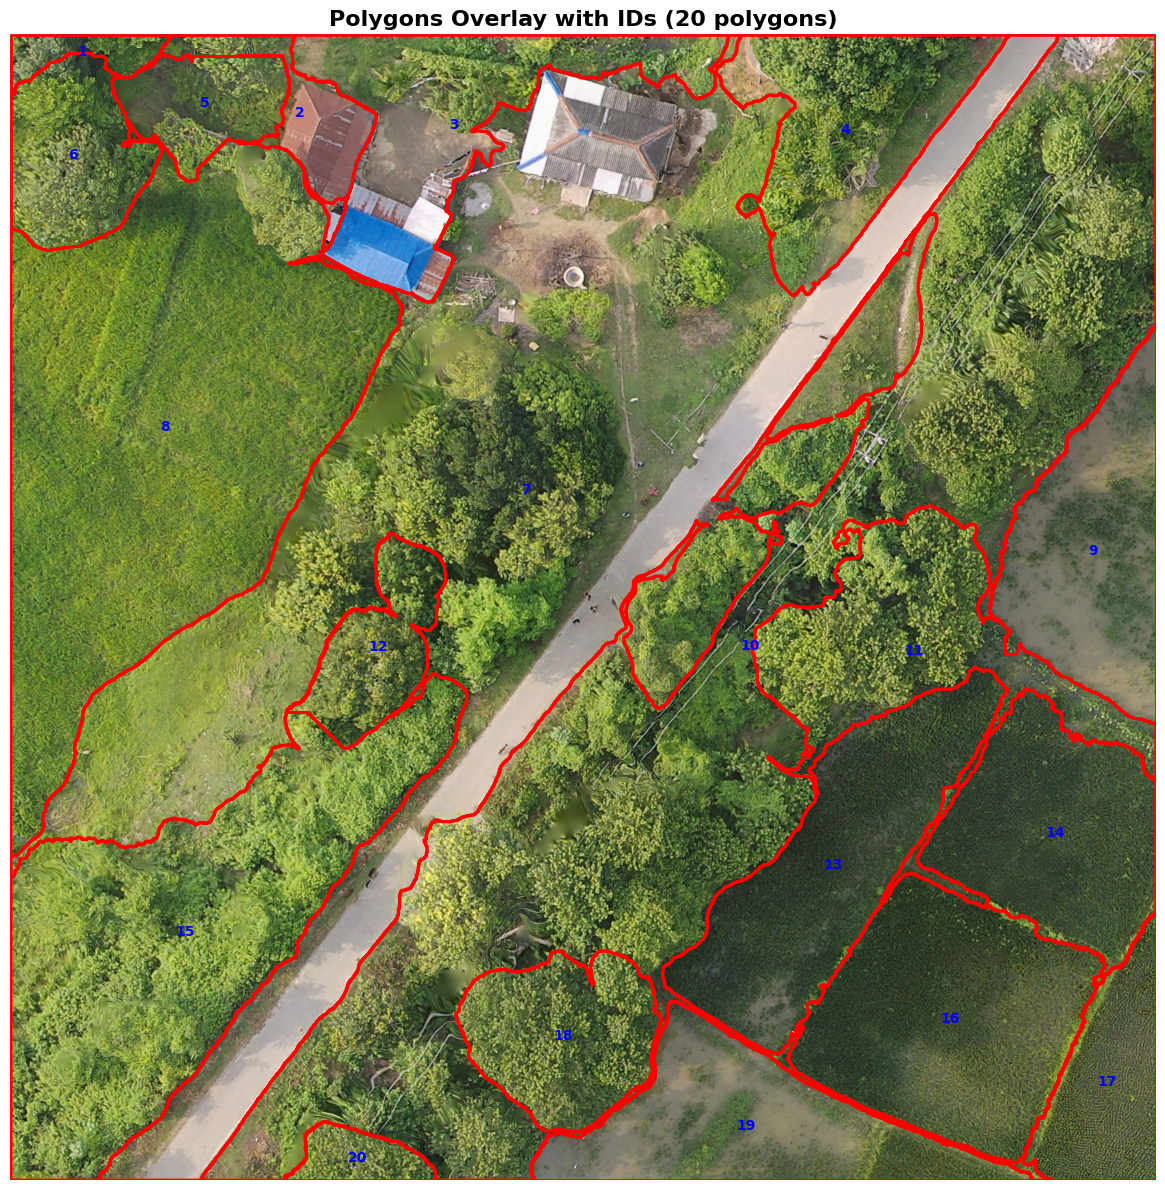


Enter the Polygon ID to get its GeoJSON:  16



GeoJSON for Polygon ID 16:
{"type": "FeatureCollection", "features": [{"id": "15", "type": "Feature", "properties": {"id": 16, "area_pixels": 177150}, "geometry": {"type": "Polygon", "coordinates": [[[490220.9442361606, 2937786.3049881286], [490220.9442361606, 2937786.2618656284], [490220.90111366066, 2937786.2618656284], [490220.90111366066, 2937786.2187431287], [490220.85799116065, 2937786.2187431287], [490220.85799116065, 2937786.2618656284], [490220.6423786606, 2937786.2618656284], [490220.6423786606, 2937786.2187431287], [490220.5561336606, 2937786.2187431287], [490220.5561336606, 2937786.132498129], [490220.51301116066, 2937786.132498129], [490220.51301116066, 2937786.0893756286], [490220.46988866065, 2937786.0893756286], [490220.46988866065, 2937786.0462531284], [490220.38364366064, 2937786.0462531284], [490220.38364366064, 2937786.0031306287], [490220.34052116063, 2937786.0031306287], [490220.34052116063, 2937785.9600081285], [490220.2973986606, 2937785.9600081285], [490220.29

In [7]:
pipeline()

In [2]:
!nvidia-smi

Sat Dec 13 06:12:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P8             11W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
!kill -9 119494